# Imports

In [66]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [67]:
# from tensorflow.keras.preprocessing.text import text_to_word_sequence
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

# Data loading

In [3]:
X_movies = pd.read_csv("./../data/sample_movies_reviews_clean.csv")
X_books = pd.read_csv("./../data/sample_books_reviews_clean.csv")

### Extracting the lists out of the strings and removing unnecessary columns

In [4]:
X_books["txt_flatten"] = X_books["txt"].apply(lambda x: eval(x))
X_movies["txt_flatten"] = X_movies["txt"].apply(lambda x: eval(x))
X_movies.drop(columns=["Unnamed: 0", "txt"], inplace=True)
X_books.drop(columns=["Unnamed: 0", "txt"], inplace=True)

In [5]:
X_books_agg = X_books.groupby("item_id").sum()
X_movies_agg = X_movies.groupby("item_id").sum()
X_books_agg["is_movie"] = 0
X_movies_agg["is_movie"] = 1
X_books_agg.reset_index(inplace=True)
X_movies_agg.reset_index(inplace=True)
X_books_agg.rename({"item_id":"item_id_book"}, axis='columns', inplace=True)
X_movies_agg.rename({"item_id":"item_id_movie"}, axis='columns',inplace=True)
X_reviews = pd.concat([X_movies_agg, X_books_agg])

### Grouping the reviews by movies_id and book_id


In [ ]:
X_movies.groupby("item_id").count().hist(bins=[*range(20)])

In [ ]:
X_books.groupby("item_id").count().hist(bins=[*range(40)])

#### Looking at the distribution of reviews lengths

In [ ]:
X_movies_agg["length_txt"] = X_movies_agg["txt_flatten"].apply(lambda x: len(x))

In [ ]:
X_movies_agg["length_txt"].hist(bins=[*range(0,250,10)])
plt.xlabel("length_txt")
plt.ylabel("Frequency")
plt.title("# of words per movie review");

In [ ]:
X_books_agg["length_txt"] = X_books_agg["txt_flatten"].apply(lambda x: len(x))

In [ ]:
X_books_agg["length_txt"].hist(bins=[*range(0,2000,100)])
plt.xlabel("length_txt")
plt.ylabel("Frequency")
plt.title("# of words per book review");

In [ ]:
X_reviews["length_txt"].hist(bins=50)
plt.xlabel("length_txt")
plt.ylabel("Frequency")
plt.title("# of words per review (book + movie)");

### Word2Vec

In [ ]:
# To list the available Word2Vec models
print(list(api.info()['models'].keys()))

In [ ]:
#TODO use another word2vec
#TODO utiliser BERT --> pas forcément besoin de preprocessing ?

In [ ]:
word2vec_transfer = api.load("glove-wiki-gigaword-300")

In [6]:
# # Store data (serialize)
# with open('./../notebook_temp/word2vec.pickle', 'wb') as handle:
#     pickle.dump(word2vec_transfer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
with open('./../notebook_temp/word2vec.pickle', 'rb') as handle:
    word2vec_transfer = pickle.load(handle)

In [ ]:
# To list Word2Vec params
print(word2vec_transfer.vector_size)
print(len(word2vec_transfer.key_to_index))

### Old embedding version

In [ ]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [ ]:
# Embed the training and test sentences
# X_embed = embedding(word2vec_transfer, X_reviews["txt_flatten"])

In [ ]:
# Pad the training and test embedded sentences
# TODO: maxlen could be increased
# X_pad = pad_sequences(X_embed, dtype='float32', padding='post', maxlen=1000, value=0)

In [ ]:
np.shape(X_embed)

In [ ]:
np.shape(X_embed[3])

### Vectorizing

In [7]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features


In [ ]:
vectorized_docs = vectorize(X_reviews["txt_flatten"], model=word2vec_transfer)

In [ ]:
len(vectorized_docs), len(vectorized_docs[0])

### BERT embedding

In [68]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch, BisectingKMeans
from sentence_transformers import SentenceTransformer

In [69]:
# bert = SentenceTransformer('all-MiniLM-L6-v2')
# # test with "all-MiniLM-L6-v2"
# # most powerful model : all-mpnet-base-v2

# # Store data (serialize)
# with open('./../notebook_temp/bert.pickle', 'wb') as handle:
#     pickle.dump(bert, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
with open('./../notebook_temp/bert.pickle', 'rb') as handle:
    bert = pickle.load(handle)

In [70]:
import glob
import os

In [71]:
# merging the files
joined_files = os.path.join("./../data/proc_data/proc_book/", "*.csv")
  
# A list of all joined files is returned
joined_list = glob.glob(joined_files)


In [72]:
  
# Finally, the files are joined
X_books_bert = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)

In [73]:
X_books_bert

,item_id,txt
0,1649,Love love love this book!!!! It made me fall i...
1,2001,Do you like predictable stories where the girl...
2,38270,The book is always better than the movie... On...
3,59082,Just when I thought I had a handle on this boo...
4,68729,I'd seen the movie a couple hundred times (don...
...,...,...
655,3602953,Patricia Cornwell's newest book opens with a g...
656,4733799,"it's like - the Bible, only more poetic... Mov..."
657,5913092,The Number 1 Ladies Detective Agency is in som...
658,10219456,"7th-adult. So, just when I was giving up on gr..."


In [74]:
X_movies_bert = pd.read_csv("./../data/proc_data/proc_movies/mov_chunk1_raw.csv")

In [75]:
X_movies_bert

,item_id,txt
0,1,The one film that started what is now a cliché...
1,2,Fun little movie hidden in the back drawer; Mo...
2,4,Extra in Movie; I was actually an extra in thi...
3,5,The Best Movie of All Time; let me tell you.. ...
4,6,One of the best films of the 90's; I am assumi...
...,...,...
11422,182283,Find this one!!!; This cartoon really deserves...
11423,182313,Great if you like the series; On the buses was...
11424,182321,I Went For The Laughs And I Got It!; This movi...
11425,182357,Worth the watch. Better than Bond in many way...


In [76]:
X_books_bert["is_movie"] = 0
X_movies_bert["is_movie"] = 1
# X_books_bert.reset_index(inplace=True)
# X_movies_bert.reset_index(inplace=True)
X_books_bert.rename({"item_id":"item_id_book"}, axis='columns', inplace=True)
X_movies_bert.rename({"item_id":"item_id_movie"}, axis='columns',inplace=True)
X_reviews_bert = pd.concat([X_movies_bert, X_books_bert], ignore_index=True)

In [77]:
# bert_embeddings = bert.encode(X_reviews_bert["txt"]) # ou doc vectorized ? 

# # Store data (serialize)
# with open('./../notebook_temp/bert_embeddings.pickle', 'wb') as handle:
#     pickle.dump(bert_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Load data (deserialize)
with open('./../notebook_temp/bert_embeddings.pickle', 'rb') as handle:
    bert_embeddings = pickle.load(handle)

In [78]:
np.shape(bert_embeddings)

(12087, 384)

In [17]:
N_CLUSTERS = 50

### MiniBatchKmeans (Old)

In [ ]:
# km = MiniBatchKMeans(n_clusters=75, batch_size=500).fit(vectorized_docs)

In [ ]:
X_reviews["batch_label"] = km.labels_

### Kmeans

In [ ]:
kmeans = KMeans(n_clusters=N_CLUSTERS).fit(vectorized_docs)

In [ ]:
kmeans_bert = KMeans(n_clusters=N_CLUSTERS).fit(bert_embeddings)

In [ ]:
X_reviews["Kmeans_label"] = kmeans.labels_
X_reviews_bert["Kmeans_label_bert"] = kmeans_bert.labels_

### Agglomerative clustering

In [54]:
clustering = AgglomerativeClustering(n_clusters=50).fit(vectorized_jeff)

In [79]:
clustering_bert = AgglomerativeClustering(n_clusters=1000).fit(bert_embeddings)

In [80]:
# X_reviews["clustering_label"] = clustering.labels_
X_reviews_bert["clustering_label_bert"] = clustering_bert.labels_

In [81]:
import scipy.cluster.hierarchy as sch

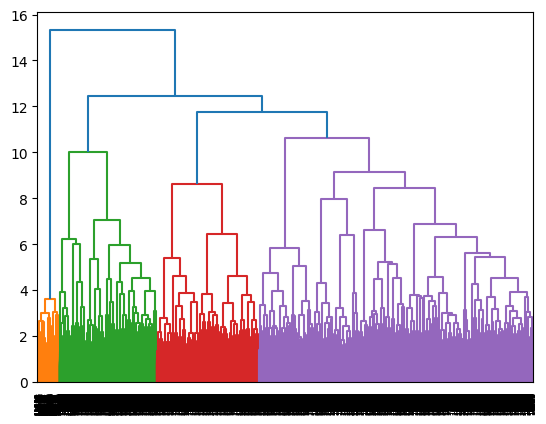

In [85]:
dendrogram = sch.dendrogram(sch.linkage(bert_embeddings, method='ward'))

#### Projector tensorflow

In [46]:
bert = merged_all_bert[["movie_title","book_title","clustering_label_bert", "is_movie"]]
bert = bert.fillna("")

In [48]:
bert["title"] = bert["movie_title"] + bert["book_title"]

In [50]:
bert.drop(columns=["movie_title", "book_title"], inplace=True)

In [51]:
bert.to_csv('bert.tsv', sep="\t")

In [44]:
pd.DataFrame(bert_embeddings)

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.079007,-0.049298,0.051513,-0.027787,-0.013174,0.059992,-0.049877,0.044862,0.060521,-0.025812,...,0.106086,0.028847,-0.016674,-0.030727,-0.037982,0.071764,0.025707,-0.015925,0.053646,0.126850
1,-0.053540,0.000282,0.015590,-0.004250,0.012114,0.038642,0.066208,0.057151,0.016414,0.046918,...,0.118308,-0.010259,-0.090554,0.073645,-0.045544,0.028873,0.112189,0.015121,-0.033950,0.047594
2,-0.042839,-0.054799,-0.034893,0.014431,-0.012506,0.060859,-0.004653,-0.001440,0.003472,-0.054092,...,0.078316,-0.067737,-0.017566,0.084620,0.007749,0.021396,-0.015340,-0.022210,-0.147625,0.001202
3,-0.085395,0.001581,-0.002437,-0.009061,0.003269,0.035443,0.018421,0.093952,0.145767,0.084204,...,0.045845,0.049183,-0.084166,0.029974,-0.042120,0.021249,0.071048,-0.014005,0.009078,-0.039007
4,-0.045171,0.037970,-0.007245,-0.033129,0.026384,0.078317,-0.005574,0.065243,0.022878,-0.038569,...,0.086511,0.030827,-0.040421,0.047738,0.012385,0.033098,0.045036,-0.031701,-0.022563,-0.026315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12082,-0.001829,-0.051105,0.054703,0.051773,0.029096,0.037651,-0.004367,0.002233,0.067764,0.018390,...,0.014033,0.046221,0.005162,0.072476,-0.041058,0.042190,-0.027285,0.032857,0.002844,-0.011957
12083,0.006569,-0.020199,-0.016572,-0.033811,0.053877,-0.060022,-0.077428,0.065245,0.050635,0.018877,...,0.054152,-0.000405,-0.037791,0.021352,-0.065171,-0.008345,0.050590,-0.004664,-0.015368,0.033915
12084,-0.102479,-0.086156,-0.032896,-0.011255,-0.074386,0.028103,0.010293,-0.010066,0.020905,-0.010566,...,0.028483,-0.004551,-0.038530,0.069576,-0.042411,0.041779,0.063140,-0.061914,-0.041203,-0.013255
12085,-0.070320,-0.013451,-0.050287,-0.003596,0.021793,0.090333,-0.027473,0.018487,0.041073,0.016177,...,0.048721,-0.022084,-0.044974,0.062123,-0.047895,0.035967,0.087970,-0.074245,-0.047531,-0.028091


In [45]:
pd.DataFrame(bert_embeddings).to_csv('embeddings.tsv', sep="\t", header=False)

#### Data Visualization

In [20]:
## Import packages

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [32]:
## Set-up of data inputs. Note that X must comprise solely vectors

sample_size = 10_000

extract = pd.DataFrame(bert_embeddings).sample(n=sample_size)

print(f"Extract shape: {extract.shape}")

Extract shape: (10000, 384)


In [33]:
## Initialization of TSNE model

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(extract)

tsne_df = pd.DataFrame()
tsne_df["comp-1"] = z[:,0]
tsne_df["comp-2"] = z[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 0.902s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.216608
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.837830
[t-SNE] KL divergence after 1000 iterations: 3.396441


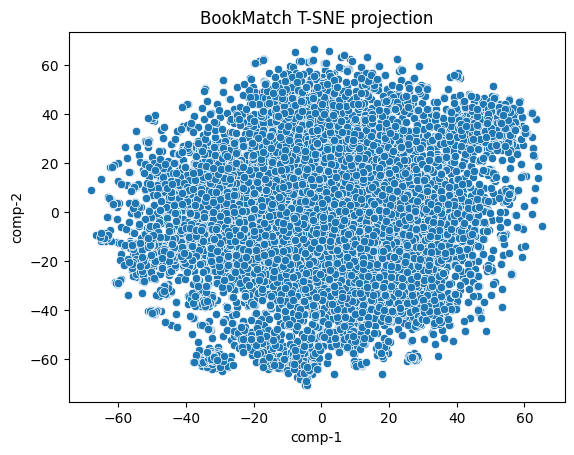

In [34]:
## Visualization of results

comp_1 = tsne_df["comp-1"]
comp_2 = tsne_df["comp-2"]

kwargs = dict (linestyle='--', color='b', marker ='o', linewidth=1.2, markersize=2)

sns.scatterplot(x="comp-1", y="comp-2",
                data=tsne_df).set(title="BookMatch T-SNE projection");

#### Silhouette scoring

In [89]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(vectorized_docs, clustering.labels_)

In [ ]:
silhouette_score(bert_embeddings, clustering_bert.labels_)

In [ ]:
linkage=['ward','complete', "average", "single"]
n_clusters=[50, 75, 100, 125, 150]
metric=["euclidian", "l1", "l2", "manhattan", "cosine"]

In [ ]:
clustering_bert = AgglomerativeClustering(n_clusters=3000, metric="cosine", linkage="complete").fit(bert_embeddings)
silhouette_score(bert_embeddings, clustering_bert.labels_)

In [ ]:
opti_k = {}

for cluster in [50,100,200]:
    opti_k[f"clustering_bert_{cluster}"] = AgglomerativeClustering(n_clusters=cluster).fit(bert_embeddings)   
    opti_k[f"silhouette_score_{cluster}"] = silhouette_score(bert_embeddings, opti_k[f"clustering_bert_{cluster}"].labels_)
    
opti_k

In [ ]:
opti_k2 = {}

for cluster in [1500, 2000, 2500, 3000]:
    opti_k2[f"clustering_bert_{cluster}"] = AgglomerativeClustering(n_clusters=cluster).fit(bert_embeddings)   
    opti_k2[f"silhouette_score_{cluster}"] = silhouette_score(bert_embeddings, opti_k2[f"clustering_bert_{cluster}"].labels_)
    
opti_k2

Text(0, 0.5, 'silhouette_score')

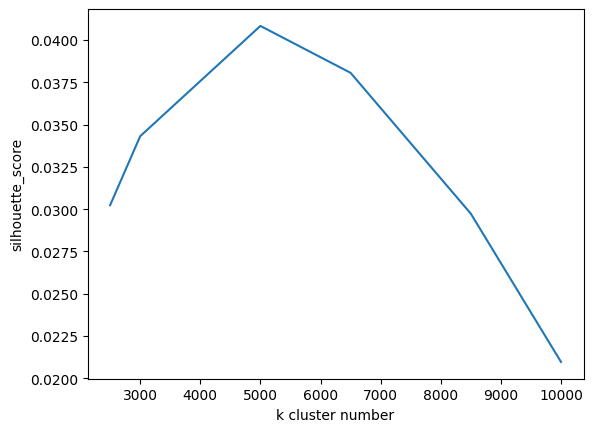

In [91]:
silhouette_scores = []
ks = [2500, 3000, 5000, 6500, 8500, 10_000]

for k in ks:
    km_test = AgglomerativeClustering(n_clusters=k).fit(bert_embeddings)
    silhouette_scores.append(silhouette_score(bert_embeddings, km_test.labels_))

plt.plot(ks, silhouette_scores)
plt.xlabel('k cluster number')
plt.ylabel('silhouette_score')

### BisectingKMeans 

In [ ]:
bisect_means = BisectingKMeans(n_clusters=N_CLUSTERS, random_state=1).fit(vectorized_docs)
bisect_means_bert = BisectingKMeans(n_clusters=N_CLUSTERS, random_state=1).fit(bert_embeddings)

In [ ]:
X_reviews["bisectings"] = bisect_means.labels_
X_reviews_bert["bisectings_bert"] = bisect_means_bert.labels_

### Loading metadata and merging it

In [37]:
metadata_movies = pd.read_json("./../data/raw_data/raw_movies/metadata.json", lines=True)
metadata_books = pd.read_json("./../data/raw_data/raw_book/metadata.json", lines=True)

In [38]:
metadata_movies.rename({"item_id":"item_id_movie", "title":"movie_title"}, axis='columns',inplace=True)
metadata_books.rename({"item_id":"item_id_book", "title":"book_title"}, axis='columns',inplace=True)

In [ ]:
merged_movies = pd.merge(X_reviews, metadata_movies, on="item_id_movie", how="left")
merged_all = pd.merge(merged_movies, metadata_books, on="item_id_book", how="left")

In [39]:
merged_movies_bert = pd.merge(X_reviews_bert, metadata_movies, on="item_id_movie", how="left")
merged_all_bert = pd.merge(merged_movies_bert, metadata_books, on="item_id_book", how="left")

In [ ]:
final_df = merged_all[["movie_title","book_title","clustering_label", "Kmeans_label", "bisectings", "is_movie" ]]
final_df = final_df.fillna("")
final_df["clustering_label"].value_counts()

In [ ]:
bert = merged_all_bert[["movie_title","book_title","clustering_label_bert", "Kmeans_label_bert", "bisectings_bert", "is_movie" ]]
bert = bert.fillna("")

In [57]:
metadata_movies

,movie_title,directedBy,starring,dateAdded,avgRating,imdbId,item_id_movie
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",None,3.89146,114709,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",None,3.26605,113497,2
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",None,3.17146,113228,3
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",None,2.86824,114885,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",None,3.07620,113041,5
...,...,...,...,...,...,...,...
84656,The Tenth Level (1976),Charles S. Dubin,"William Shatner,Lynn Carlin,Ossie Davis,Viveca...",2021-02-11T20:42:38,0.00000,75320,239306
84657,Nightmare (1974),William Hale,"Richard Crenna,Patty Duke,Vic Morrow,Arlene Go...",2021-02-11T20:43:02,0.00000,71911,239308
84658,Pee Nak (2019),Phontharis Chotkijsadarsopon,"Chinawut Indracusin,Paisarnkulwong Vachiravit,...",2021-02-11T22:52:12,0.00000,8258474,239310
84659,Pee Nak 2 (2020),Phontharis Chotkijsadarsopon,"วชิรวิชญ์ ไพศาลกุลวงศ์,ภูริพรรธน์ เวชวงศาเตชาว...",2021-02-11T22:53:01,0.00000,11906412,239312


In [56]:
bert

,clustering_label_bert,is_movie,title
0,60,1,Toy Story (1995)
1,288,1,Jumanji (1995)
2,738,1,Waiting to Exhale (1995)
3,223,1,Father of the Bride Part II (1995)
4,163,1,Heat (1995)
...,...,...,...
12082,275,0,"Book of the Dead (Kay Scarpetta, #15)"
12083,277,0,The Silmarillion
12084,561,0,Morality for Beautiful Girls (No. 1 Ladies' De...
12085,653,0,"Runaways, Vol. 1: Pride and Joy (Runaways, #1)"


In [ ]:
final_df[final_df["movie_title"].str.contains("potter", case=False)]

In [ ]:
final_df[final_df["book_title"].str.contains("potter", case=False)]

In [ ]:
bert[bert["movie_title"].str.contains("potter", case=False)]

In [ ]:
bert[bert["book_title"].str.contains("potter", case=False)]